In [1]:
import numpy as np
import pandas as pd
# import ace_tools as tools
from scipy.stats import norm
import matplotlib.pyplot as plt

# Configuration
k = 10
n_problems = 1000
n_steps = 2000
noise_std = 0.01  # sqrt of 0.01^2
revert_kappa = 0.5

# Set fixed seeds (one per arm)
arm_seeds = [100 + i for i in range(k)]

**Gradual Changes- drift change**

In [2]:
# Function to generate evolving means under revert
def generate_drift_means(n_problems, n_steps, k, noise_std, arm_seeds):
    all_means = np.zeros((n_problems, n_steps, k))
    for p in range(n_problems):
        rngs = [np.random.default_rng(seed) for seed in arm_seeds]
        initial_mu = np.random.normal(0, 1, k)
        all_means[p, 0] = initial_mu
        for t in range(1, n_steps):
            drift = np.array([rng.normal(0, noise_std) for rng in rngs])
            all_means[p, t] = all_means[p, t - 1] + drift
    return all_means

# Update greedy_non_optimistic to use time-varying means
def greedy_non_optimistic_non_stationary(k, n_steps, n_problems, means):
    rewards = np.zeros((n_problems, n_steps))
    optimal_action_counts = np.zeros((n_problems, n_steps))

    for p in range(n_problems):
        action_values = np.zeros(k)
        action_counts = np.zeros(k)

        for step in range(n_steps):
            mu_step = means[p, step]
            action = np.argmax(action_values)
            reward = np.random.normal(mu_step[action], 1)

            rewards[p, step] = reward
            optimal_action_counts[p, step] = (action == np.argmax(mu_step))

            action_counts[action] += 1
            action_values[action] += (reward - action_values[action]) / action_counts[action]

    return rewards, optimal_action_counts

# Update epsilon-greedy to use time-varying means
def epsilon_greedy_non_stationary(k, n_steps, n_problems, ep, means):
    rewards = np.zeros((n_problems, n_steps))
    optimal_action_counts = np.zeros((n_problems, n_steps))

    for p in range(n_problems):
        action_values = np.zeros(k)
        action_counts = np.zeros(k)

        for step in range(n_steps):
            mu_step = means[p, step]
            if np.random.rand() < ep:
                action = np.random.randint(k)
            else:
                action = np.argmax(action_values)

            reward = np.random.normal(mu_step[action], 1)
            rewards[p, step] = reward
            optimal_action_counts[p, step] = (action == np.argmax(mu_step))
            action_counts[action] += 1
            action_values[action] += (reward - action_values[action]) / action_counts[action]

    return rewards, optimal_action_counts

# Update optimistic greedy to use time-varying means
def optimistic_greedy_non_stationary(k, n_steps, n_problems, means):
    rewards = np.zeros((n_problems, n_steps))
    optimal_action_counts = np.zeros((n_problems, n_steps))

    for p in range(n_problems):
        max_mu = np.max(means[p, 0])
        optimistic_value = norm.ppf(0.995, loc=max_mu, scale=1)
        action_values = np.ones(k) * optimistic_value
        action_counts = np.zeros(k)

        for step in range(n_steps):
            mu_step = means[p, step]
            action = np.argmax(action_values)
            reward = np.random.normal(mu_step[action], 1)
            rewards[p, step] = reward
            optimal_action_counts[p, step] = (action == np.argmax(mu_step))
            action_counts[action] += 1
            action_values[action] += (reward - action_values[action]) / action_counts[action]

    return rewards, optimal_action_counts

# Update gradient bandit to use time-varying means
def gradient_bandit_non_stationary(k, n_steps, n_problems, alpha, means):
    rewards = np.zeros((n_problems, n_steps))
    optimal_action_counts = np.zeros((n_problems, n_steps))

    for p in range(n_problems):
        preferences = np.zeros(k)
        average_reward = 0

        for step in range(n_steps):
            mu_step = means[p, step]
            exp_preferences = np.exp(preferences - np.max(preferences))  # for numerical stability
            action_probabilities = exp_preferences / np.sum(exp_preferences)
            action = np.random.choice(k, p=action_probabilities)
            reward = np.random.normal(mu_step[action], 1)

            rewards[p, step] = reward
            optimal_action_counts[p, step] = (action == np.argmax(mu_step))

            for a in range(k):
                if a == action:
                    preferences[a] += alpha * (reward - average_reward) * (1 - action_probabilities[a])
                else:
                    preferences[a] -= alpha * (reward - average_reward) * action_probabilities[a]

            average_reward += (reward - average_reward) / (step + 1)

    return rewards, optimal_action_counts


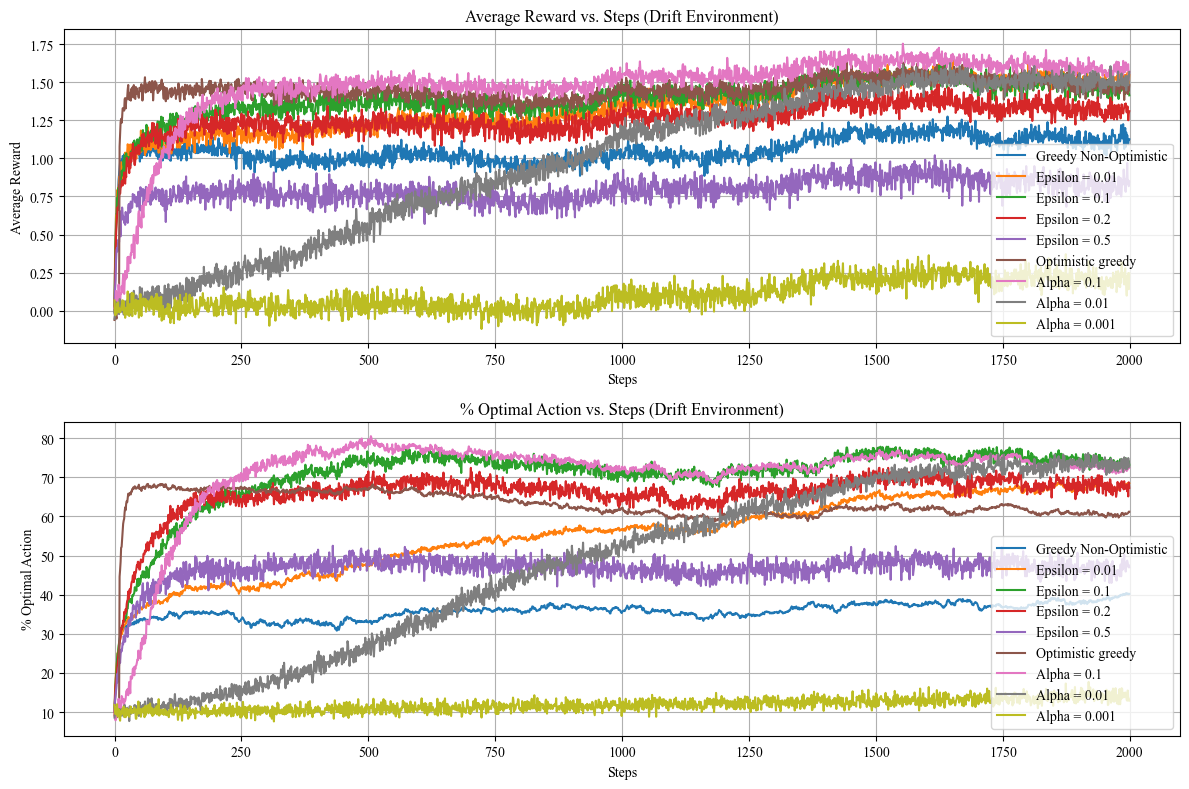

In [3]:
# Generate full drift-based means for all problems
drift_means_full = generate_drift_means(n_problems, n_steps, k, noise_std, arm_seeds)

# Run Greedy (non-optimistic) under drift
greedy_rewards, greedy_optimal_action_counts = greedy_non_optimistic_non_stationary(k, n_steps, n_problems, drift_means_full)
avg_greedy_rewards = np.mean(greedy_rewards, axis=0)
avg_greedy_optimal_action_percentage = np.mean(greedy_optimal_action_counts, axis=0) * 100

# Run Epsilon-Greedy with multiple epsilons under drift
ep_values = [0.01, 0.1, 0.2, 0.5]
epsilon_results = {}
for ep in ep_values:
    rewards, optimal_action_counts = epsilon_greedy_non_stationary(k, n_steps, n_problems, ep, drift_means_full)
    avg_rewards = np.mean(rewards, axis=0)
    avg_optimal_action_percentage = np.mean(optimal_action_counts, axis=0) * 100
    epsilon_results[ep] = (avg_rewards, avg_optimal_action_percentage)

# Run Optimistic Greedy under drift
optimistic_rewards, optimistic_optimal_action_counts = optimistic_greedy_non_stationary(k, n_steps, n_problems, drift_means_full)
avg_optimistic_rewards = np.mean(optimistic_rewards, axis=0)
avg_optimistic_optimal_action_percentage = np.mean(optimistic_optimal_action_counts, axis=0) * 100

# Run Gradient Bandit with multiple alphas under drift
alphas = [0.1, 0.01, 0.001]
gradient_bandit_results = {}
for alpha in alphas:
    rewards, optimal_action_counts = gradient_bandit_non_stationary(k, n_steps, n_problems, alpha, drift_means_full)
    avg_rewards = np.mean(rewards, axis=0)
    avg_optimal_action_percentage = np.mean(optimal_action_counts, axis=0) * 100
    gradient_bandit_results[alpha] = (avg_rewards, avg_optimal_action_percentage)

# Plotting the results
# Set global font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(12, 8))

# Plot average rewards for all algorithms
plt.subplot(2, 1, 1)
plt.plot(avg_greedy_rewards, label='Greedy Non-Optimistic')
for ep in ep_values:
    avg_rewards, _ = epsilon_results[ep]
    plt.plot(avg_rewards, label=f'Epsilon = {ep}')
plt.plot(avg_optimistic_rewards, label='Optimistic greedy')
for alpha in alphas:
    avg_rewards, _ = gradient_bandit_results[alpha]
    plt.plot(avg_rewards, label=f'Alpha = {alpha}')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.grid(True)
plt.title('Average Reward vs. Steps (Drift Environment)')
plt.legend()

# Plot optimal action percentages for all algorithms
plt.subplot(2, 1, 2)
plt.plot(avg_greedy_optimal_action_percentage, label='Greedy Non-Optimistic')
for ep in ep_values:
    _, avg_optimal_action_percentage = epsilon_results[ep]
    plt.plot(avg_optimal_action_percentage, label=f'Epsilon = {ep}')
plt.plot(avg_optimistic_optimal_action_percentage, label='Optimistic greedy')
for alpha in alphas:
    _, avg_optimal_action_percentage = gradient_bandit_results[alpha]
    plt.plot(avg_optimal_action_percentage, label=f'Alpha = {alpha}')
plt.xlabel('Steps')
plt.ylabel('% Optimal Action')
plt.grid(True)
plt.title('% Optimal Action vs. Steps (Drift Environment)')
plt.legend()

plt.tight_layout()
plt.show()


C:\Users\Tinh Thanh Bui\AppData\Local\Temp\ipykernel_17952\3589808041.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_reward, labels=label_reward)
C:\Users\Tinh Thanh Bui\AppData\Local\Temp\ipykernel_17952\3589808041.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_action, labels=label_reward)


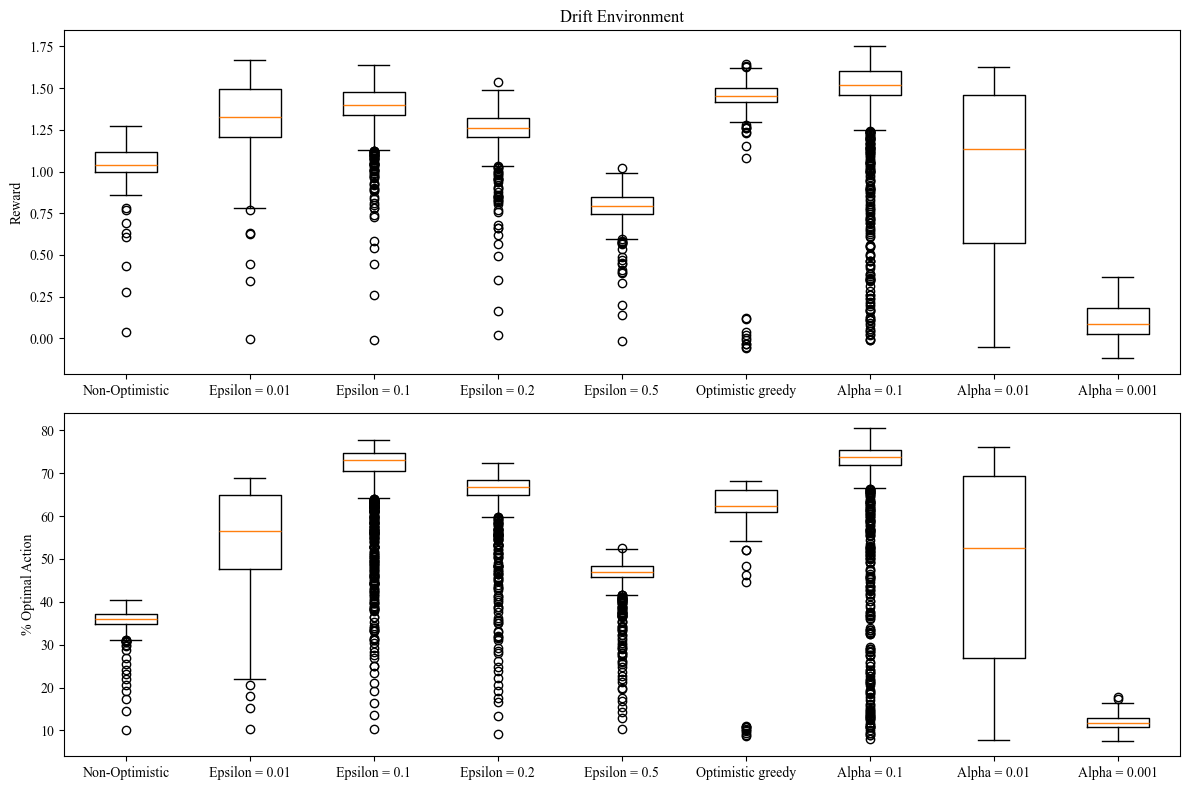

In [4]:
# Plotting the results
plt.figure(figsize=(12, 8))

# Plot average rewards for all algorithms
plt.subplot(2, 1, 1)
data_reward = []
label_reward = []
data_reward.append(avg_greedy_rewards)
label_reward.append('Non-Optimistic')
for ep in ep_values:
    avg_rewards, _ = epsilon_results[ep]
    data_reward.append(avg_rewards)
    label_reward.append(f'Epsilon = {ep}')
data_reward.append(avg_optimistic_rewards)
label_reward.append('Optimistic greedy')
for alpha in alphas:
    avg_rewards, _ = gradient_bandit_results[alpha]
    data_reward.append(avg_rewards)
    label_reward.append(f'Alpha = {alpha}')
    
plt.boxplot(data_reward, labels=label_reward)
plt.ylabel('Reward')
plt.title('Drift Environment')

# Plot optimal action percentages for all algorithms
plt.subplot(2, 1, 2)
data_action = []
data_action.append(avg_greedy_optimal_action_percentage)
for ep in ep_values:
    _, avg_optimal_action_percentage = epsilon_results[ep]
    data_action.append(avg_optimal_action_percentage)
data_action.append(avg_optimistic_optimal_action_percentage)
for alpha in alphas:
    _, avg_optimal_action_percentage = gradient_bandit_results[alpha]
    data_action.append(avg_optimal_action_percentage)

plt.boxplot(data_action, labels=label_reward)
plt.ylabel('% Optimal Action')
plt.tight_layout()
plt.show()

**Gradual Changes-mean-reverting change**

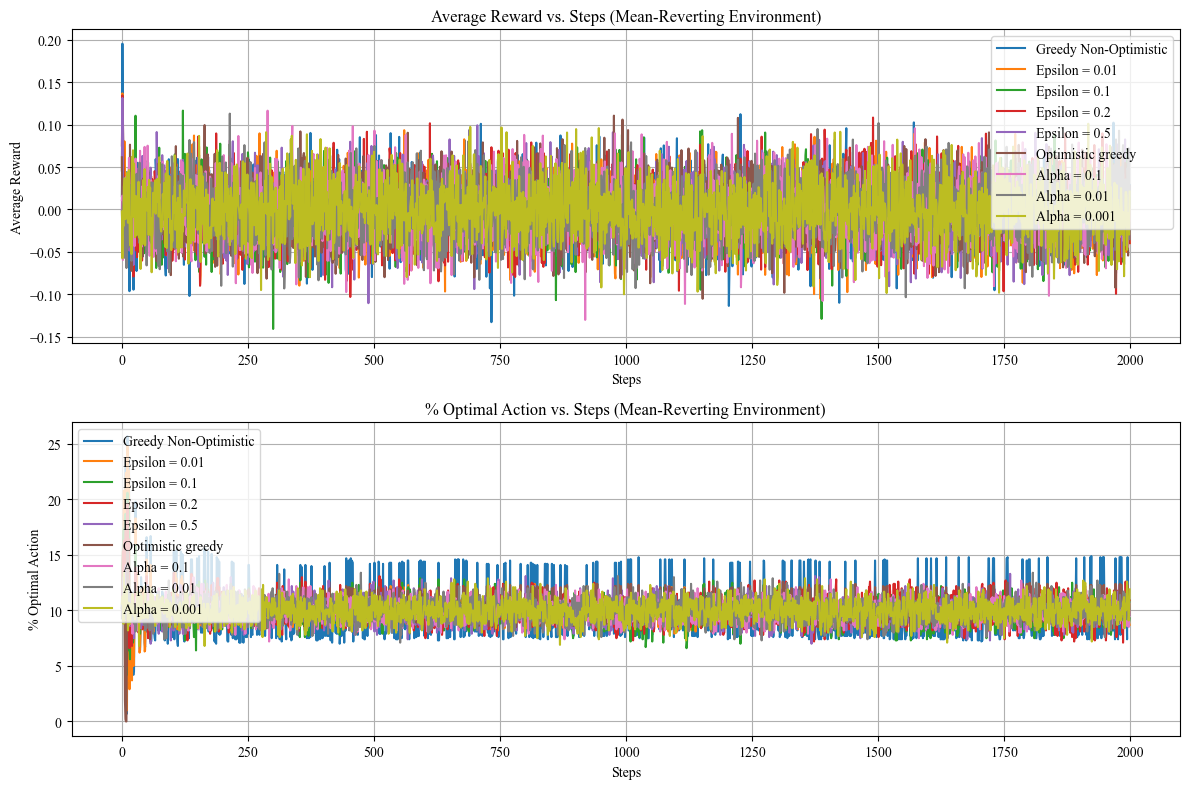

In [5]:
# Function to generate evolving means under mean-reverting dynamics
def generate_mean_reverting_means(n_problems, n_steps, k, revert_kappa, noise_std, arm_seeds):
    all_means = np.zeros((n_problems, n_steps, k))
    for p in range(n_problems):
        rngs = [np.random.default_rng(seed) for seed in arm_seeds]
        initial_mu = np.random.normal(0, 1, k)
        all_means[p, 0] = initial_mu
        for t in range(1, n_steps):
            noise = np.array([rng.normal(0, noise_std) for rng in rngs])
            all_means[p, t] = revert_kappa * all_means[p, t - 1] + noise
    return all_means

# Generate full reverting means for all problems
revert_means_full = generate_mean_reverting_means(n_problems, n_steps, k, revert_kappa, noise_std, arm_seeds)

# Run Greedy (non-optimistic) under revert
greedy_rewards, greedy_optimal_action_counts = greedy_non_optimistic_non_stationary(k, n_steps, n_problems, revert_means_full)
avg_greedy_rewards = np.mean(greedy_rewards, axis=0)
avg_greedy_optimal_action_percentage = np.mean(greedy_optimal_action_counts, axis=0) * 100

# Run Epsilon-Greedy with multiple epsilons under revert
ep_values = [0.01, 0.1, 0.2, 0.5]
epsilon_results = {}
for ep in ep_values:
    rewards, optimal_action_counts = epsilon_greedy_non_stationary(k, n_steps, n_problems, ep, revert_means_full)
    avg_rewards = np.mean(rewards, axis=0)
    avg_optimal_action_percentage = np.mean(optimal_action_counts, axis=0) * 100
    epsilon_results[ep] = (avg_rewards, avg_optimal_action_percentage)

# Run Optimistic Greedy under revert
optimistic_rewards, optimistic_optimal_action_counts = optimistic_greedy_non_stationary(k, n_steps, n_problems, revert_means_full)
avg_optimistic_rewards = np.mean(optimistic_rewards, axis=0)
avg_optimistic_optimal_action_percentage = np.mean(optimistic_optimal_action_counts, axis=0) * 100

# Run Gradient Bandit with multiple alphas under revert
alphas = [0.1, 0.01, 0.001]
gradient_bandit_results = {}
for alpha in alphas:
    rewards, optimal_action_counts = gradient_bandit_non_stationary(k, n_steps, n_problems, alpha, revert_means_full)
    avg_rewards = np.mean(rewards, axis=0)
    avg_optimal_action_percentage = np.mean(optimal_action_counts, axis=0) * 100
    gradient_bandit_results[alpha] = (avg_rewards, avg_optimal_action_percentage)

# Plotting the results
plt.figure(figsize=(12, 8))

# Plot average rewards for all algorithms
plt.subplot(2, 1, 1)
plt.plot(avg_greedy_rewards, label='Greedy Non-Optimistic')
for ep in ep_values:
    avg_rewards, _ = epsilon_results[ep]
    plt.plot(avg_rewards, label=f'Epsilon = {ep}')
plt.plot(avg_optimistic_rewards, label='Optimistic greedy')
for alpha in alphas:
    avg_rewards, _ = gradient_bandit_results[alpha]
    plt.plot(avg_rewards, label=f'Alpha = {alpha}')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.grid(True)
plt.title('Average Reward vs. Steps (Mean-Reverting Environment)')
plt.legend()

# Plot optimal action percentages for all algorithms
plt.subplot(2, 1, 2)
plt.plot(avg_greedy_optimal_action_percentage, label='Greedy Non-Optimistic')
for ep in ep_values:
    _, avg_optimal_action_percentage = epsilon_results[ep]
    plt.plot(avg_optimal_action_percentage, label=f'Epsilon = {ep}')
plt.plot(avg_optimistic_optimal_action_percentage, label='Optimistic greedy')
for alpha in alphas:
    _, avg_optimal_action_percentage = gradient_bandit_results[alpha]
    plt.plot(avg_optimal_action_percentage, label=f'Alpha = {alpha}')
plt.xlabel('Steps')
plt.ylabel('% Optimal Action')
plt.grid(True)
plt.title('% Optimal Action vs. Steps (Mean-Reverting Environment)')
plt.legend()

plt.tight_layout()
plt.show()



C:\Users\Tinh Thanh Bui\AppData\Local\Temp\ipykernel_17952\929665157.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_reward, labels=label_reward)
C:\Users\Tinh Thanh Bui\AppData\Local\Temp\ipykernel_17952\929665157.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_action, labels=label_reward)


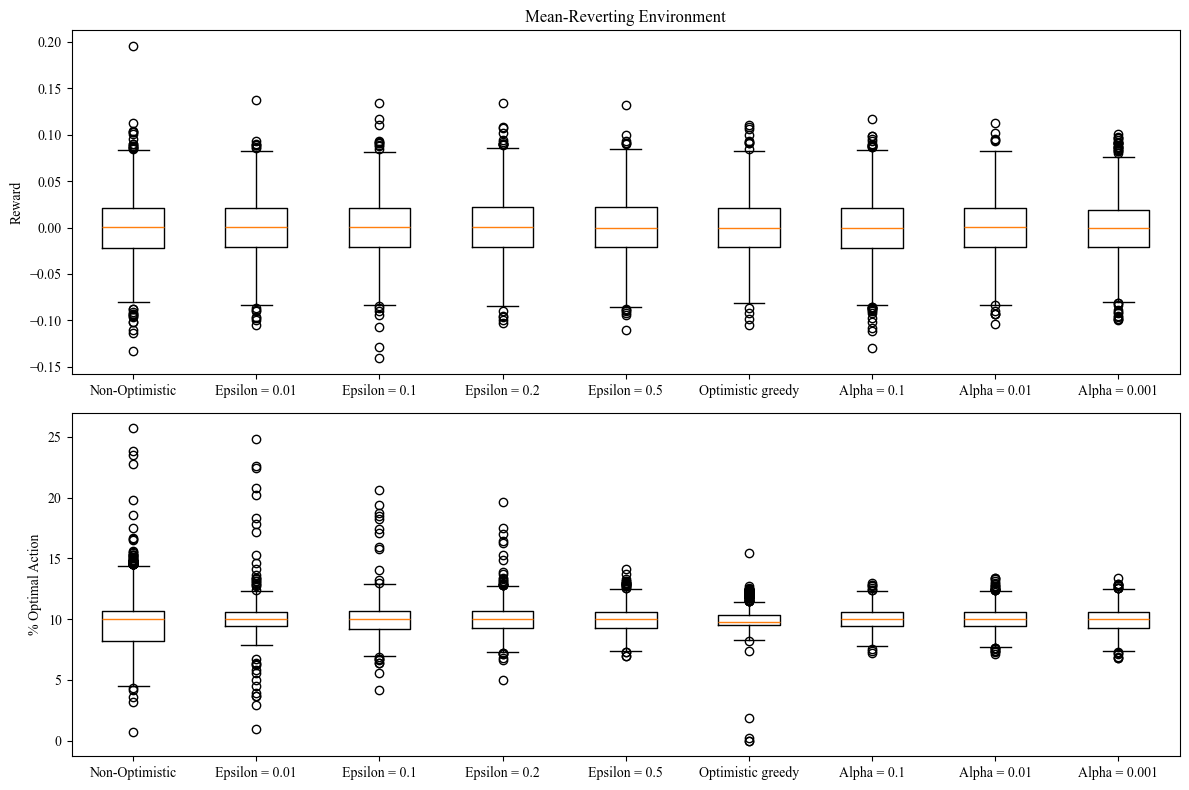

In [6]:
# Plotting the results
plt.figure(figsize=(12, 8))

# Plot average rewards for all algorithms
plt.subplot(2, 1, 1)
data_reward = []
label_reward = []
data_reward.append(avg_greedy_rewards)
label_reward.append('Non-Optimistic')
for ep in ep_values:
    avg_rewards, _ = epsilon_results[ep]
    data_reward.append(avg_rewards)
    label_reward.append(f'Epsilon = {ep}')
data_reward.append(avg_optimistic_rewards)
label_reward.append('Optimistic greedy')
for alpha in alphas:
    avg_rewards, _ = gradient_bandit_results[alpha]
    data_reward.append(avg_rewards)
    label_reward.append(f'Alpha = {alpha}')
    
plt.boxplot(data_reward, labels=label_reward)
plt.ylabel('Reward')
plt.title('Mean-Reverting Environment')

# Plot optimal action percentages for all algorithms
plt.subplot(2, 1, 2)
data_action = []
data_action.append(avg_greedy_optimal_action_percentage)
for ep in ep_values:
    _, avg_optimal_action_percentage = epsilon_results[ep]
    data_action.append(avg_optimal_action_percentage)
data_action.append(avg_optimistic_optimal_action_percentage)
for alpha in alphas:
    _, avg_optimal_action_percentage = gradient_bandit_results[alpha]
    data_action.append(avg_optimal_action_percentage)

plt.boxplot(data_action, labels=label_reward)
plt.ylabel('% Optimal Action')
plt.tight_layout()
plt.show()

**Abrupt changes: Randomly permute the means at t = 501**

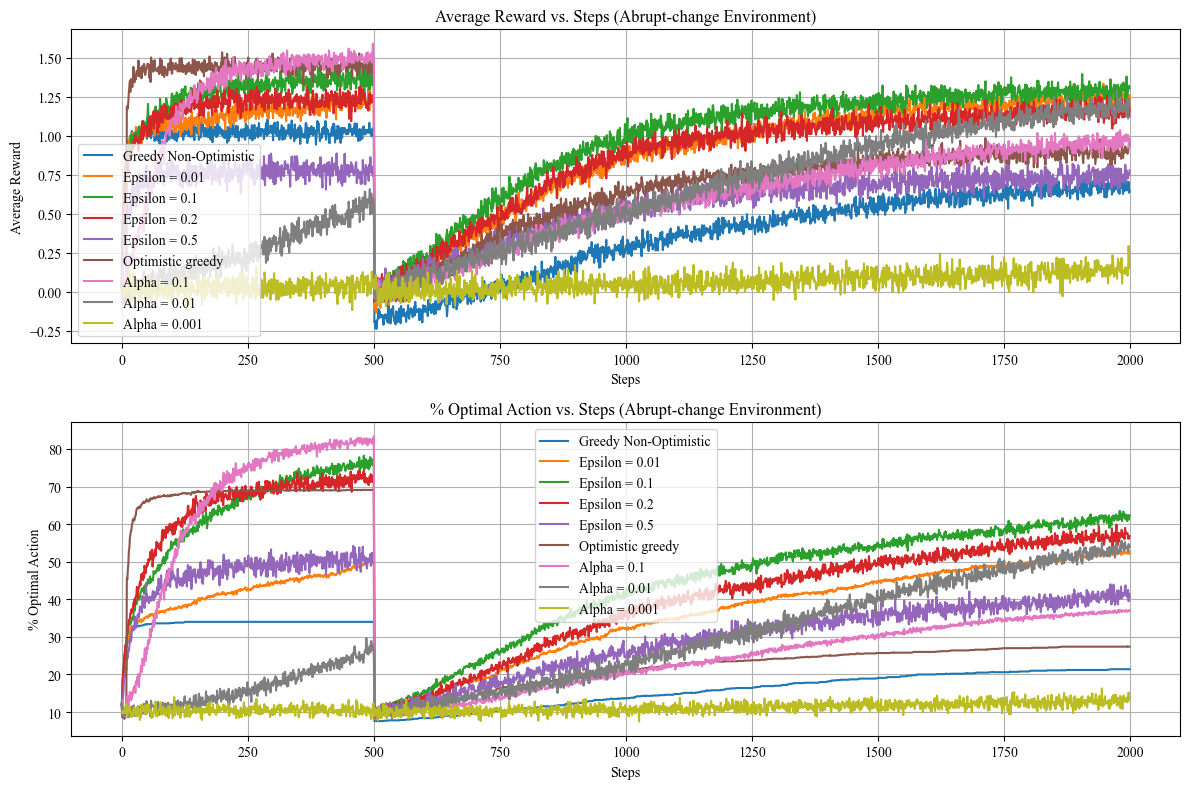

In [7]:
# Function to generate evolving means with abrupt change at t = 501
def generate_abrupt_means(n_problems, n_steps, k, change_point):
    all_means = np.zeros((n_problems, n_steps, k))
    abrupt_permutation = np.argsort(np.random.default_rng(42).random(k))  # fixed permutation for all problems

    for p in range(n_problems):
        initial_mu = np.random.normal(0, 1, k)
        all_means[p, 0] = initial_mu

        for t in range(1, n_steps):
            all_means[p, t] = all_means[p, t - 1]
            # Apply permutation starting at the change point
            if t == change_point:
                all_means[p, t] = all_means[p, t][abrupt_permutation]
    return all_means, abrupt_permutation

# Generate and preview abrupt means for 5 problems and 10 steps (showing around the change point)
abrupt_means_full, abrupt_perm = generate_abrupt_means(n_problems, n_steps, k, 501)

# Run Greedy (non-optimistic) under revert
greedy_rewards, greedy_optimal_action_counts = greedy_non_optimistic_non_stationary(k, n_steps, n_problems, abrupt_means_full)
avg_greedy_rewards = np.mean(greedy_rewards, axis=0)
avg_greedy_optimal_action_percentage = np.mean(greedy_optimal_action_counts, axis=0) * 100

# Run Epsilon-Greedy with multiple epsilons under revert
ep_values = [0.01, 0.1, 0.2, 0.5]
epsilon_results = {}
for ep in ep_values:
    rewards, optimal_action_counts = epsilon_greedy_non_stationary(k, n_steps, n_problems, ep, abrupt_means_full)
    avg_rewards = np.mean(rewards, axis=0)
    avg_optimal_action_percentage = np.mean(optimal_action_counts, axis=0) * 100
    epsilon_results[ep] = (avg_rewards, avg_optimal_action_percentage)

# Run Optimistic Greedy under revert
optimistic_rewards, optimistic_optimal_action_counts = optimistic_greedy_non_stationary(k, n_steps, n_problems, abrupt_means_full)
avg_optimistic_rewards = np.mean(optimistic_rewards, axis=0)
avg_optimistic_optimal_action_percentage = np.mean(optimistic_optimal_action_counts, axis=0) * 100

# Run Gradient Bandit with multiple alphas under revert
alphas = [0.1, 0.01, 0.001]
gradient_bandit_results = {}
for alpha in alphas:
    rewards, optimal_action_counts = gradient_bandit_non_stationary(k, n_steps, n_problems, alpha, abrupt_means_full)
    avg_rewards = np.mean(rewards, axis=0)
    avg_optimal_action_percentage = np.mean(optimal_action_counts, axis=0) * 100
    gradient_bandit_results[alpha] = (avg_rewards, avg_optimal_action_percentage)

# Plotting the results
plt.figure(figsize=(12, 8))

# Plot average rewards for all algorithms
plt.subplot(2, 1, 1)
plt.plot(avg_greedy_rewards, label='Greedy Non-Optimistic')
for ep in ep_values:
    avg_rewards, _ = epsilon_results[ep]
    plt.plot(avg_rewards, label=f'Epsilon = {ep}')
plt.plot(avg_optimistic_rewards, label='Optimistic greedy')
for alpha in alphas:
    avg_rewards, _ = gradient_bandit_results[alpha]
    plt.plot(avg_rewards, label=f'Alpha = {alpha}')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.grid(True)
plt.title('Average Reward vs. Steps (Abrupt-change Environment)')
plt.legend()

# Plot optimal action percentages for all algorithms
plt.subplot(2, 1, 2)
plt.plot(avg_greedy_optimal_action_percentage, label='Greedy Non-Optimistic')
for ep in ep_values:
    _, avg_optimal_action_percentage = epsilon_results[ep]
    plt.plot(avg_optimal_action_percentage, label=f'Epsilon = {ep}')
plt.plot(avg_optimistic_optimal_action_percentage, label='Optimistic greedy')
for alpha in alphas:
    _, avg_optimal_action_percentage = gradient_bandit_results[alpha]
    plt.plot(avg_optimal_action_percentage, label=f'Alpha = {alpha}')
plt.xlabel('Steps')
plt.ylabel('% Optimal Action')
plt.grid(True)
plt.title('% Optimal Action vs. Steps (Abrupt-change Environment)')
plt.legend()

plt.tight_layout()
plt.show()



C:\Users\Tinh Thanh Bui\AppData\Local\Temp\ipykernel_17952\83929540.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_reward, labels=label_reward)
C:\Users\Tinh Thanh Bui\AppData\Local\Temp\ipykernel_17952\83929540.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_action, labels=label_reward)


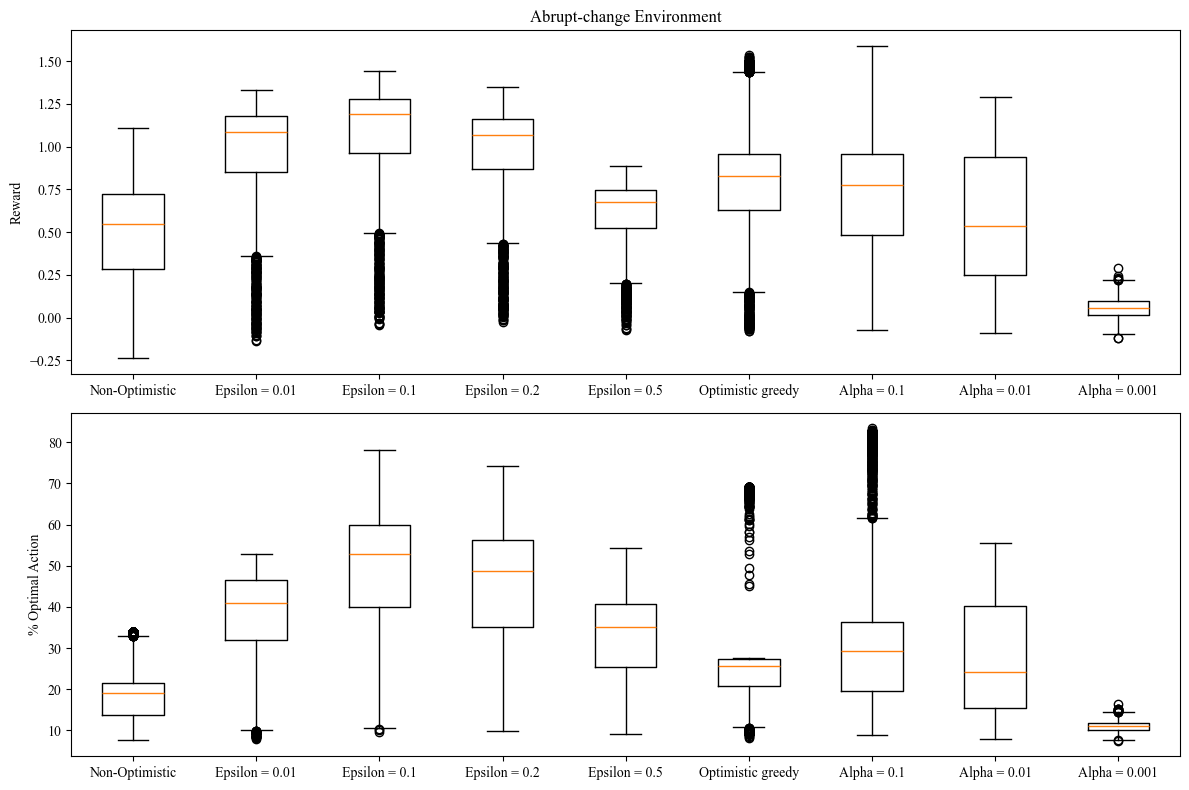

In [8]:
# Plotting the results
plt.figure(figsize=(12, 8))

# Plot average rewards for all algorithms
plt.subplot(2, 1, 1)
data_reward = []
label_reward = []
data_reward.append(avg_greedy_rewards)
label_reward.append('Non-Optimistic')
for ep in ep_values:
    avg_rewards, _ = epsilon_results[ep]
    data_reward.append(avg_rewards)
    label_reward.append(f'Epsilon = {ep}')
data_reward.append(avg_optimistic_rewards)
label_reward.append('Optimistic greedy')
for alpha in alphas:
    avg_rewards, _ = gradient_bandit_results[alpha]
    data_reward.append(avg_rewards)
    label_reward.append(f'Alpha = {alpha}')
    
plt.boxplot(data_reward, labels=label_reward)
plt.ylabel('Reward')
plt.title('Abrupt-change Environment')

# Plot optimal action percentages for all algorithms
plt.subplot(2, 1, 2)
data_action = []
data_action.append(avg_greedy_optimal_action_percentage)
for ep in ep_values:
    _, avg_optimal_action_percentage = epsilon_results[ep]
    data_action.append(avg_optimal_action_percentage)
data_action.append(avg_optimistic_optimal_action_percentage)
for alpha in alphas:
    _, avg_optimal_action_percentage = gradient_bandit_results[alpha]
    data_action.append(avg_optimal_action_percentage)

plt.boxplot(data_action, labels=label_reward)
plt.ylabel('% Optimal Action')
plt.tight_layout()
plt.show()

**Abrupt changes: Hard reset all action values at t = 501**

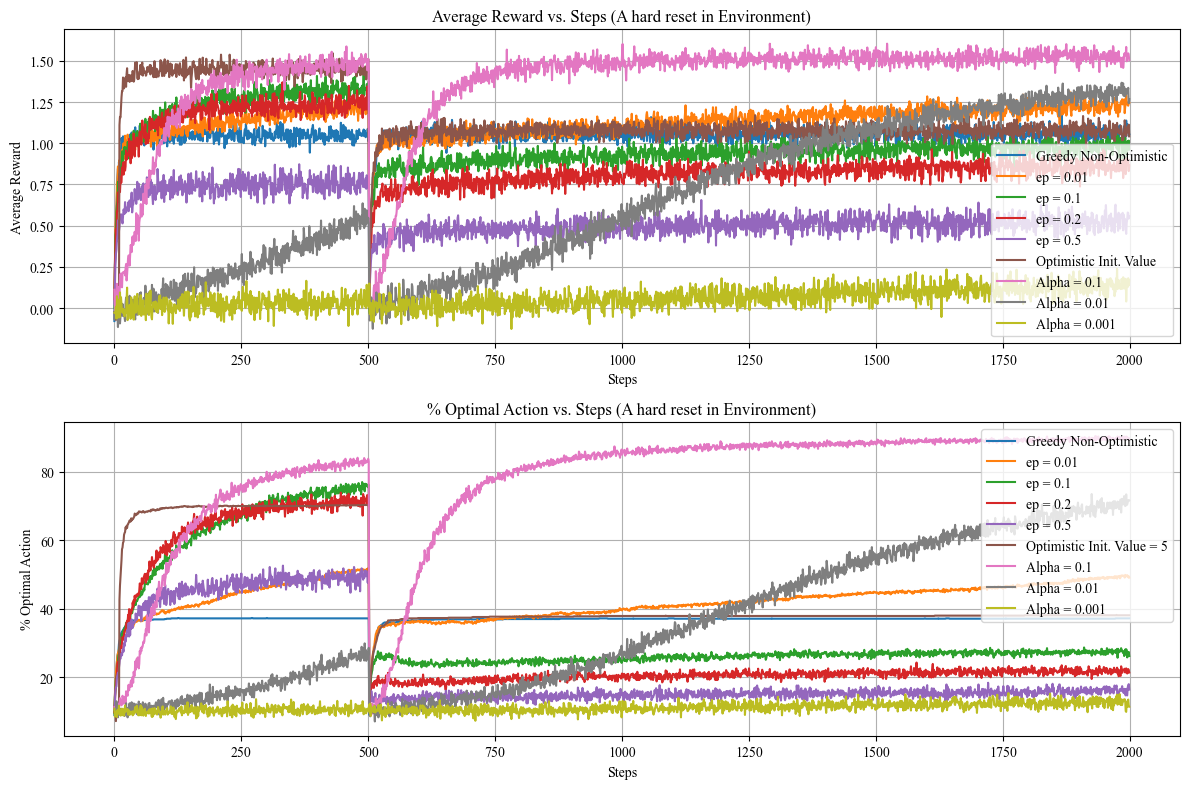

In [9]:
# Function to generate means for the k-armed bandit
def generate_means(k):
    return np.random.normal(0, 1, k)

# Function to generate rewards based on the means
def generate_rewards(means):
    return np.random.normal(means, 1)

# Greedy algorithm with non-optimistic initial values
def greedy_non_optimistic(k, n_steps, n_problems):
    rewards = np.zeros((n_problems, n_steps))
    optimal_action_counts = np.zeros((n_problems, n_steps))

    for p in range(n_problems):
        means = generate_means(k)  # Generate means for the k-armed bandit
        action_values = np.zeros(k)  # Initialize action value estimates to 0
        action_counts = np.zeros(k)  # Initialize action counts to 0

        for step in range(n_steps):
            action = np.argmax(action_values)  # Select the action with the highest estimated value
            reward = generate_rewards(means)[action]  # Generate the reward for the chosen action

            rewards[p, step] = reward  # Store the reward
            optimal_action_counts[p, step] = (action == np.argmax(means))  # Check if the optimal action was chosen

            action_counts[action] += 1  # Update the action count
            # Update the action value estimate using the incremental method
            action_values[action] += (reward - action_values[action]) / action_counts[action]
            # Apply a hard reset at t = 501
            if step == 501:
                action_values = np.zeros(k)

    return rewards, optimal_action_counts

# Epsilon-greedy algorithm
def epsilon_greedy(k, n_steps, n_problems, ep):
    rewards = np.zeros((n_problems, n_steps))
    optimal_action_counts = np.zeros((n_problems, n_steps))

    for p in range(n_problems):
        means = generate_means(k)  # Generate means for the k-armed bandit
        action_values = np.zeros(k)  # Initialize action value estimates to 0
        action_counts = np.zeros(k)  # Initialize action counts to 0

        for step in range(n_steps):
            if np.random.rand() < ep:
                action = np.random.randint(k)  # Explore: select a random action
            else:
                action = np.argmax(action_values)  # Exploit: select the best-known action

            reward = generate_rewards(means)[action]  # Generate the reward for the chosen action
            rewards[p, step] = reward  # Store the reward
            optimal_action_counts[p, step] = (action == np.argmax(means))  # Check if the optimal action was chosen
            action_counts[action] += 1  # Update the action count
            # Update the action value estimate using the incremental method
            action_values[action] += (reward - action_values[action]) / action_counts[action]
            # Apply a hard reset at t = 501
            if step == 501:
                action_values = np.zeros(k)
                
    return rewards, optimal_action_counts

# Optimistic Greedy
def optimistic_greedy(k, n_steps, n_problems):
    rewards = np.zeros((n_problems, n_steps))
    optimal_action_counts = np.zeros((n_problems, n_steps))

    for p in range(n_problems):
        means = generate_means(k)
        max_mu = np.max(means)
        optimistic_value = norm.ppf(0.995, loc=max_mu, scale=1) # the 99.5th percentile of the normal distribution with the highest Mu
        action_values = np.ones(k) * optimistic_value  # Set optimistic initial values based on 
        action_counts = np.zeros(k)

        for step in range(n_steps):
            action = np.argmax(action_values)
            reward = generate_rewards(means)[action]
            rewards[p, step] = reward
            optimal_action_counts[p, step] = (action == np.argmax(means))
            action_counts[action] += 1
            action_values[action] += (reward - action_values[action]) / action_counts[action]
            # Apply a hard reset at t = 501
            if step == 501:
                action_values = np.zeros(k)
                
    return rewards, optimal_action_counts

# Gradient Bandit algorithm
def gradient_bandit(k, n_steps, n_problems, alpha):
    rewards = np.zeros((n_problems, n_steps))
    optimal_action_counts = np.zeros((n_problems, n_steps))

    for p in range(n_problems):
        means = generate_means(k)  # Generate means for the k-armed bandit
        preferences = np.zeros(k)  # Initialize preferences to 0
        average_reward = 0  # Initialize the average reward

        for step in range(n_steps):
            exp_preferences = np.exp(preferences)
            action_probabilities = exp_preferences / np.sum(exp_preferences)  # Softmax to get action probabilities
            action = np.random.choice(k, p=action_probabilities)  # Choose action based on probabilities
            reward = generate_rewards(means)[action]  # Generate reward for the chosen action
            rewards[p, step] = reward  # Store the reward
            optimal_action_counts[p, step] = (action == np.argmax(means))  # Check if the optimal action was chosen
            # Update preferences
            for a in range(k):
                if a == action:
                    preferences[a] += alpha * (reward - average_reward) * (1 - action_probabilities[a])
                else:
                    preferences[a] -= alpha * (reward - average_reward) * action_probabilities[a]

            # Update average reward
            average_reward += (reward - average_reward) / (step + 1)
            # Apply a hard reset at t = 501
            if step == 501:
                preferences = np.zeros(k)

    return rewards, optimal_action_counts


# Run the greedy_non_optimistic algorithm
greedy_rewards, greedy_optimal_action_counts = greedy_non_optimistic(k, n_steps, n_problems)
avg_greedy_rewards = np.mean(greedy_rewards, axis=0)
avg_greedy_optimal_action_percentage = np.mean(greedy_optimal_action_counts, axis=0) * 100

# Run the epsilon_greedy algorithm with different epsilon values
ep_values = [0.01, 0.1, 0.2, 0.5]
epsilon_results = {}
for ep in ep_values:
    rewards, optimal_action_counts = epsilon_greedy(k, n_steps, n_problems, ep)
    avg_rewards = np.mean(rewards, axis=0)
    avg_optimal_action_percentage = np.mean(optimal_action_counts, axis=0) * 100
    epsilon_results[ep] = (avg_rewards, avg_optimal_action_percentage)

# Run the optimistic_greedy algorithm with an initial value of the 99.5th percentile of the normal distribution with the highest Mu
optimistic_rewards, optimistic_optimal_action_counts = optimistic_greedy(k, n_steps, n_problems)
avg_optimistic_rewards = np.mean(optimistic_rewards, axis=0)
avg_optimistic_optimal_action_percentage = np.mean(optimistic_optimal_action_counts, axis=0) * 100

# Run the gradient_bandit algorithm with different learning rates
alphas = [0.1, 0.01, 0.001]
gradient_bandit_results = {}
for alpha in alphas:
    rewards, optimal_action_counts = gradient_bandit(k, n_steps, n_problems, alpha)
    avg_rewards = np.mean(rewards, axis=0)
    avg_optimal_action_percentage = np.mean(optimal_action_counts, axis=0) * 100
    gradient_bandit_results[alpha] = (avg_rewards, avg_optimal_action_percentage)

# Plotting the results
plt.figure(figsize=(12, 8))

# Plot average rewards for all algorithms
plt.subplot(2, 1, 1)
plt.plot(avg_greedy_rewards, label='Greedy Non-Optimistic')
for ep in ep_values:
    avg_rewards, _ = epsilon_results[ep]
    plt.plot(avg_rewards, label=f'ep = {ep}')
plt.plot(avg_optimistic_rewards, label='Optimistic Init. Value')
for alpha in alphas:
    avg_rewards, _ = gradient_bandit_results[alpha]
    plt.plot(avg_rewards, label=f'Alpha = {alpha}')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.grid(True)
plt.title('Average Reward vs. Steps (A hard reset in Environment)')
plt.legend()

# Plot optimal action percentages for all algorithms
plt.subplot(2, 1, 2)
plt.plot(avg_greedy_optimal_action_percentage, label='Greedy Non-Optimistic')
for ep in ep_values:
    _, avg_optimal_action_percentage = epsilon_results[ep]
    plt.plot(avg_optimal_action_percentage, label=f'ep = {ep}')
plt.plot(avg_optimistic_optimal_action_percentage, label='Optimistic Init. Value = 5')
for alpha in alphas:
    _, avg_optimal_action_percentage = gradient_bandit_results[alpha]
    plt.plot(avg_optimal_action_percentage, label=f'Alpha = {alpha}')
plt.xlabel('Steps')
plt.ylabel('% Optimal Action')
plt.grid(True)
plt.title('% Optimal Action vs. Steps (A hard reset in Environment)')
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\Tinh Thanh Bui\AppData\Local\Temp\ipykernel_17952\20167133.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_reward, labels=label_reward)
C:\Users\Tinh Thanh Bui\AppData\Local\Temp\ipykernel_17952\20167133.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_action, labels=label_reward)


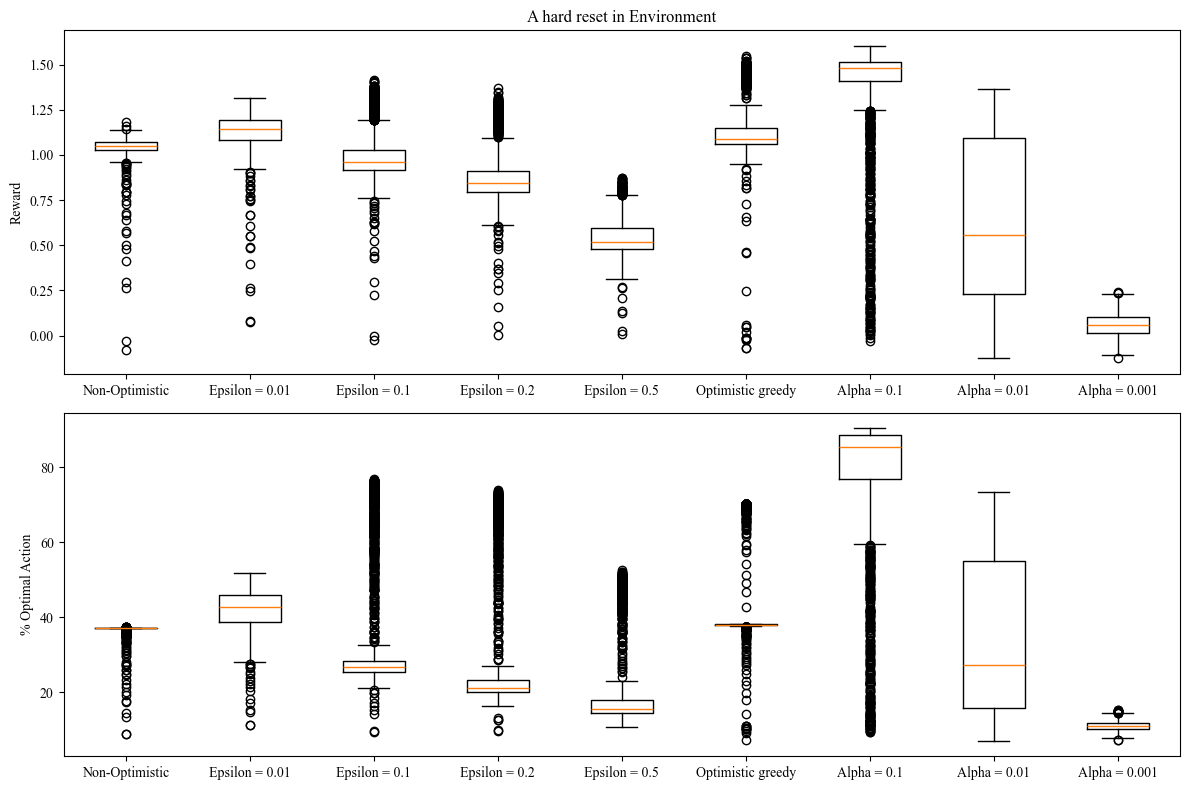

In [10]:
# Plotting the results
plt.figure(figsize=(12, 8))

# Plot average rewards for all algorithms
plt.subplot(2, 1, 1)
data_reward = []
label_reward = []
data_reward.append(avg_greedy_rewards)
label_reward.append('Non-Optimistic')
for ep in ep_values:
    avg_rewards, _ = epsilon_results[ep]
    data_reward.append(avg_rewards)
    label_reward.append(f'Epsilon = {ep}')
data_reward.append(avg_optimistic_rewards)
label_reward.append('Optimistic greedy')
for alpha in alphas:
    avg_rewards, _ = gradient_bandit_results[alpha]
    data_reward.append(avg_rewards)
    label_reward.append(f'Alpha = {alpha}')
    
plt.boxplot(data_reward, labels=label_reward)
plt.ylabel('Reward')
plt.title('A hard reset in Environment')

# Plot optimal action percentages for all algorithms
plt.subplot(2, 1, 2)
data_action = []
data_action.append(avg_greedy_optimal_action_percentage)
for ep in ep_values:
    _, avg_optimal_action_percentage = epsilon_results[ep]
    data_action.append(avg_optimal_action_percentage)
data_action.append(avg_optimistic_optimal_action_percentage)
for alpha in alphas:
    _, avg_optimal_action_percentage = gradient_bandit_results[alpha]
    data_action.append(avg_optimal_action_percentage)

plt.boxplot(data_action, labels=label_reward)
plt.ylabel('% Optimal Action')
plt.tight_layout()
plt.show()